<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [42]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Подгрузили данные и необходимые библиотеки. Колонке с датой присвоен статус индекса и изменен тип данных

In [43]:
data = data.resample('1H').sum()
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Провели ресемплирование данных с суммированием

In [44]:
def make_features(data, max_lag):    

    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour

    data['rolling_mean'] = data['num_orders'].rolling(24).mean()
    data['rolling_mean_fast'] = data['num_orders'].rolling(5).mean()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
make_features(data, 2)

print(data.head(11))

                     num_orders  day_of_week  hour  rolling_mean  \
datetime                                                           
2018-03-01 00:00:00         124            3     0           NaN   
2018-03-01 01:00:00          85            3     1           NaN   
2018-03-01 02:00:00          71            3     2           NaN   
2018-03-01 03:00:00          66            3     3           NaN   
2018-03-01 04:00:00          43            3     4           NaN   
2018-03-01 05:00:00           6            3     5           NaN   
2018-03-01 06:00:00          12            3     6           NaN   
2018-03-01 07:00:00          15            3     7           NaN   
2018-03-01 08:00:00          34            3     8           NaN   
2018-03-01 09:00:00          69            3     9           NaN   
2018-03-01 10:00:00          64            3    10           NaN   

                     rolling_mean_fast  lag_1  lag_2  
datetime                                              
2018-

Добавили дополнительные колонки для корректности фичей для обучения. Добавлены месяц, неделя, день, день недели, час, скользящая средняя, принимающая значения последних суток и лаги, т.е. предыдущие значения

## Анализ

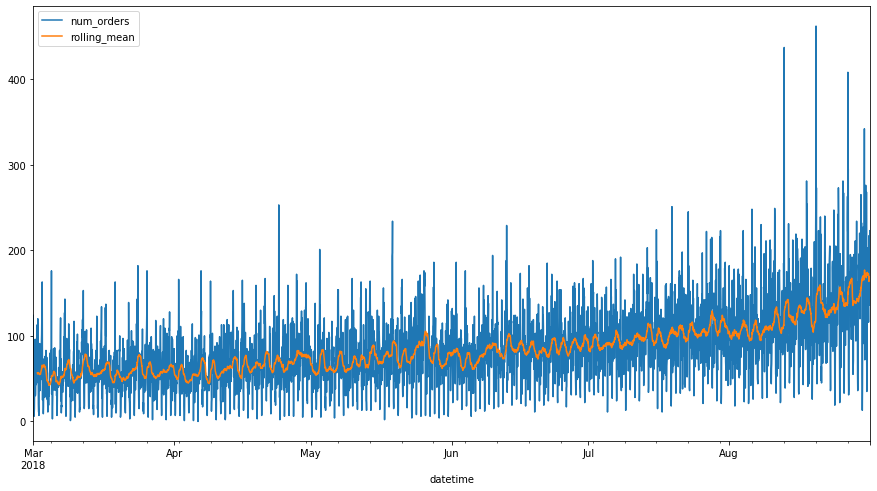

In [45]:
data[['num_orders', 'rolling_mean']].plot(figsize=(15,8))

plt.show()

На графике показаны общие данные по заказам в час с дополнительной скользящей средней. Явно прослеживается постепенное увеличение спроса к лету и самые высокие значения в августе

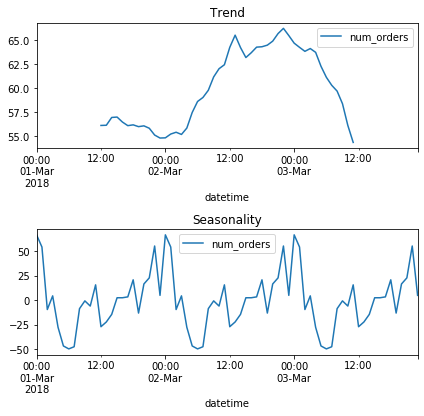

In [46]:
data_analize = data[['num_orders']]['2018-03-01':'2018-03-03']
decomposed = seasonal_decompose(data_analize) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

Сделал отдельный график тренда и сезонности для двух мартовских дней. Благодаря этим графикам становится ясно, что самый высокий спрос наблюдается в районе полуночи, а график сезонности подсказывает, что это явление не случайно и повторяется изо дня в день

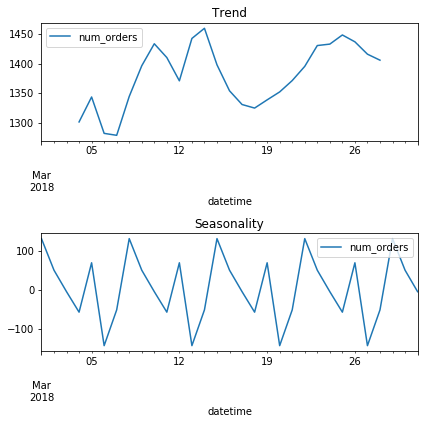

In [47]:
data_analize = data[['num_orders']]['2018-03-01':'2018-03-31'].resample('1D').sum()
decomposed = seasonal_decompose(data_analize) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

## Обучение

In [48]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print (len(train), len(test))

3951 442


In [49]:
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

Разделили трейн и тест, воспользовавшись аргументом *shuffle*, дабы избежать изменение порядка данных. Трейн и тест взяты в пропорции 9 к 1

In [50]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_test, predictions)**0.5)

RMSE обучающей выборки: 47.851841742638015


In [ ]:
clf = RandomForestRegressor()
split_index = TimeSeriesSplit().split(features_train)
params = {'n_estimators': range(10, 101, 10),
          'max_depth': range(1, 11, 1)}

grid = GridSearchCV(clf, params, cv=split_index)
grid.fit(features_train, target_train)

grid.best_params_

In [11]:
model = RandomForestRegressor(n_estimators=80, max_depth=10, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_test, predictions)**0.5)

RMSE обучающей выборки: 45.12602880759909


In [12]:
model = RandomForestRegressor(n_estimators=60, max_depth=8, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_test, predictions)**0.5)

RMSE обучающей выборки: 46.550769348393416


In [ ]:
# clf = lgb.LGBMRegressor()
# split_index = TimeSeriesSplit().split(features_train)
# params = {'n_estimators': range(100, 301, 10),
#           'max_depth': range(1, 11, 1),
#           'boosting_type': ['gbdt', 'dart', 'goss'],
#           'learning_rate': [0.001, 0.01, 0.1, 1]}

# grid = GridSearchCV(clf, params, cv=split_index)
# grid.fit(features_train, target_train)

# grid.best_params_

In [14]:
model = lgb.LGBMRegressor(n_estimators=150, max_depth=9, learning_rate=1, boosting_type='dart',random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("MSE обучающей выборки:", mean_squared_error(target_test, predictions)**0.5)

MSE обучающей выборки: 46.85362371436363


## Тестирование

Я наверное немного неверно скомпоновал, но в целом вся нужная работа проведена в предыдущем модуле. На наших данных мы обучили линейную регрессию, случайный лес и LGBMRegressor

Лучшие результаты показала модель случайного леса. Гиперпараметры были подобраны через GridSearch

Надеюсь, что уловил направление, по которому нужно было идти в работе. С твоей помощью будет улучшать

С уважением

In [51]:
model = RandomForestRegressor(n_estimators=80, max_depth=10, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_test, predictions)**0.5)

RMSE обучающей выборки: 45.12602880759909


In [53]:
pred = pd.DataFrame(predictions, columns=['values'])
target_test = pd.DataFrame(target_test)
target_test['pred'] = pred.values
display(target_test)

,num_orders,pred
datetime,,
2018-08-13 14:00:00,102,115.787296
2018-08-13 15:00:00,175,122.640094
2018-08-13 16:00:00,144,145.146876
2018-08-13 17:00:00,152,118.550732
2018-08-13 18:00:00,104,119.483655
...,...,...
2018-08-31 19:00:00,136,125.696250
2018-08-31 20:00:00,154,125.247764
2018-08-31 21:00:00,159,132.651024


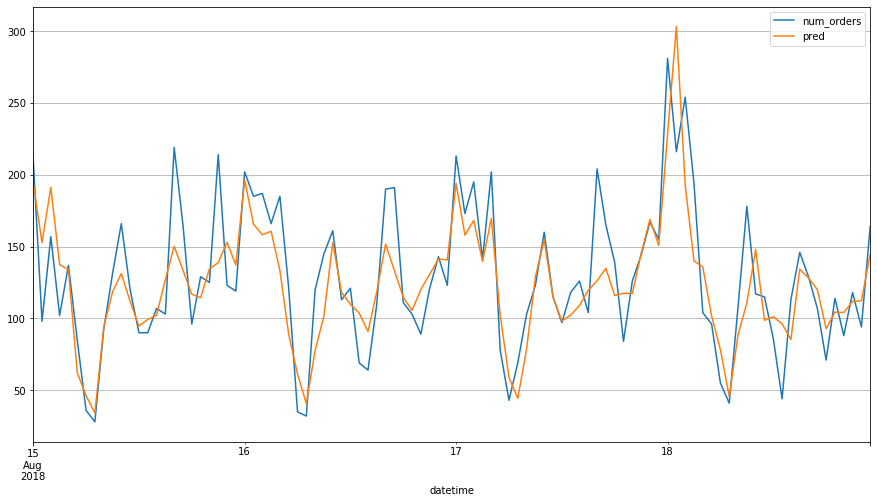

In [56]:
target_test[['num_orders', 'pred']]['2018-08-15':'2018-08-18'].plot(figsize=(15,8), grid=True)

plt.show()